# Tools and dependencies

In [9]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables


You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
  Using cached tables-3.7.0-cp310-cp310-macosx_10_9_x86_64.whl (6.0 MB)


In [3]:
import io
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform


In [157]:
import os

import httpx


class Clickhouse:
    credentials = {
        "user": 'backend',
        "password": 'rYWCG5jILwR1iBD',
    }
    url = 'http://staging-api.sensorehab.com:8123'

    def __init__(self):
        self._httpx_client = httpx.Client()

    def post(
        self,
        query: str,
        headers: dict = None,
        content: bytes = None,
    ) -> str:
        response = self._httpx_client.post(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
            content=content,
        )
        return response.text

    def get(
        self,
        query: str,
        headers: dict = None,
    ) -> str:
        response = self._httpx_client.get(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
        )
        return response.text


# Load data

In [204]:
df = None
try:
    df = pd.read_hdf('./data/dataset_gross_ml_labled_staging.h5')
except FileNotFoundError:
    pass


In [205]:
if df is None:
    ch = Clickhouse()
    pos_csv_str = ch.get('SELECT * FROM raw_data WHERE patient_id = 866 FORMAT CSV')
    print(pos_csv_str[:200])


14091,12,866,8,"2023-11-14 11:57:30.913","00:00:00:00:00:00",2,-99,0,0,0,0.826918,0.529186,-0.127107,-0.141469,-0.052,0.204,0.085,1.653,9.746,0.5,1.146065,0.839445,0.519375,0.075067,-0.141232,0.079,0.


In [206]:
if df is None:
    df = pd.read_csv(
        io.StringIO(pos_csv_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id', 'timestamp', 'src',
            'side', 'h_rssi', 'h_gain', 'g_rssi', 'g_gain', 'forearm_quat_x',
            'forearm_quat_y', 'forearm_quat_z', 'forearm_quat_w', 'forearm_lia_x',
            'forearm_lia_y', 'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y',
            'forearm_grv_z', 'forearm_tilt', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x', 'shoulder_grv_y',
            'shoulder_grv_z', 'shoulder_tilt', 'position_type', 'predict_position_type',
        ],
    )
    # df.to_hdf('./data/dataset_gross_ml_labled_staging.h5', key='df', mode='w')


In [207]:
df.head(10)


,game_result_id,game_id,patient_id,exercise_id,timestamp,src,side,h_rssi,h_gain,g_rssi,...,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type,predict_position_type
0,14091,12,866,8,2023-11-14 11:57:30.913,00:00:00:00:00:00,2,-99,0,0,...,-0.141232,0.079,0.223,0.051,9.292,-3.281,-0.446,1.017449,0,0
1,14091,12,866,8,2023-11-14 11:57:30.933,00:00:00:00:00:00,2,-99,0,0,...,-0.140972,0.022,0.199,-0.006,9.242,-3.242,-0.486,1.017901,0,0
2,14091,12,866,8,2023-11-14 11:57:30.937,00:00:00:00:00:00,2,-99,0,0,...,-0.140972,0.022,0.199,-0.006,9.242,-3.242,-0.486,1.017901,0,0
3,14091,12,866,8,2023-11-14 11:57:30.951,00:00:00:00:00:00,2,-99,0,0,...,-0.141095,0.096,0.160,-0.033,9.242,-3.163,-0.446,1.017743,0,0
4,14091,12,866,8,2023-11-14 11:57:30.968,00:00:00:00:00:00,2,-99,0,0,...,-0.141090,0.118,-0.051,-0.011,9.317,-2.987,-0.544,1.017667,0,0
5,14091,12,866,8,2023-11-14 11:57:30.984,00:00:00:00:00:00,2,-99,0,0,...,-0.141186,0.131,0.224,0.052,9.317,-3.222,-0.387,1.017695,0,0
6,14091,12,866,8,2023-11-14 11:57:31.001,00:00:00:00:00:00,2,-99,0,0,...,-0.141190,0.065,0.248,0.014,9.260,-3.261,-0.427,1.017554,0,0
7,14091,12,866,8,2023-11-14 11:57:31.018,00:00:00:00:00:00,2,-99,0,0,...,-0.141191,0.084,0.224,0.043,9.297,-3.242,-0.427,1.017364,0,0
8,14091,12,866,8,2023-11-14 11:57:31.035,00:00:00:00:00:00,2,-99,0,0,...,-0.141195,0.044,0.258,0.079,9.315,-3.300,-0.446,1.017350,0,0
9,14091,12,866,8,2023-11-14 11:57:31.051,00:00:00:00:00:00,2,-99,0,0,...,-0.141195,0.045,0.257,0.079,9.315,-3.300,-0.446,1.017350,0,0


# Extract angles

In [208]:
def calc_ang_to_Y(row):
    w, x, y, z = row.to_list()
    rotation = scipy_transform.Rotation.from_quat([x, y, z, w])
    vec = rotation.apply([0, 1, 0])
    rad_angle = np.arcsin(vec[2])
    deg_angle = math.degrees(rad_angle)
    return -deg_angle


In [209]:
forearm_quat = [
    'forearm_quat_x',
    'forearm_quat_y',
    'forearm_quat_z',
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)
df['forearm_y_ang'].head(5)


0   -65.664686
1   -65.701016
2   -65.701016
3   -65.694271
4   -65.693375
Name: forearm_y_ang, dtype: float64

In [210]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)
df['shoulder_y_ang'].head(5)


0   -58.295508
1   -58.321430
2   -58.321430
3   -58.312353
4   -58.308016
Name: shoulder_y_ang, dtype: float64

In [211]:
def calc_forearm_shoulder_ang(row):
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle


In [212]:
forearm_shoulder_quats = [
    'forearm_quat_x',
    'forearm_quat_y',
    'forearm_quat_z',
    'forearm_quat_w',
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang,
    axis=1
)
df['forearm_shoulder_ang'].head(5)


0    12.468417
1    12.393208
2    12.393208
3    12.379624
4    12.371629
Name: forearm_shoulder_ang, dtype: float64

# Charting

In [213]:
def plot_mark_ranges_preds(result_id, key='position_type_window'):
    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    # result_df = result_df.iloc[0:2500]

    patient_ids = result_df['patient_id'].unique()
    assert len(patient_ids) == 1
    patient_id = patient_ids[0]

    # 'ArrowDown' positionType = 1; BLACK
    start_mark_locs = result_df.loc[result_df[key] == 1].index
    # 'ArrowUp' positionType = 2; RED
    end_mark_locs = result_df.loc[result_df[key] == 2].index

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()


In [214]:
PATIENT_IDS = df['patient_id'].unique()
PATIENT_IDS


array([866])

In [215]:
sorted(df['game_result_id'].unique())


[14091, 14092, 14093, 14094, 14095, 14098, 14099, 14100, 14103]

In [216]:
for i in df['game_result_id'].unique():
    print(df.loc[df['game_result_id'] ==  i, :]['exercise_id'].unique())


[8]
[8]
[7]
[7]
[7]
[8]
[7]
[7]
[7]


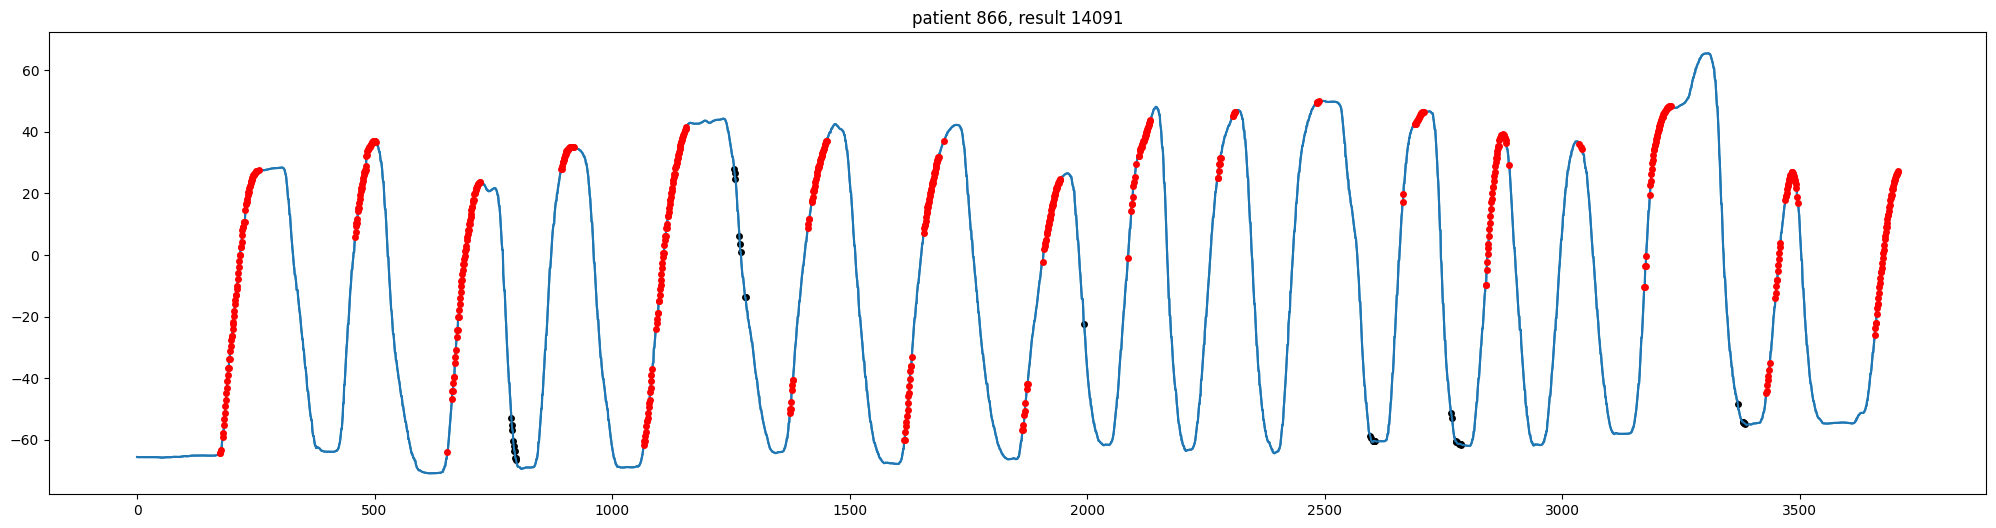

<Figure size 640x480 with 0 Axes>

In [217]:
plot_mark_ranges_preds(result_id=14091, key='position_type')


In [218]:
df[(df['game_result_id'] == 14091) & (df['position_type'] == 2)]['position_type'].count()
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


694

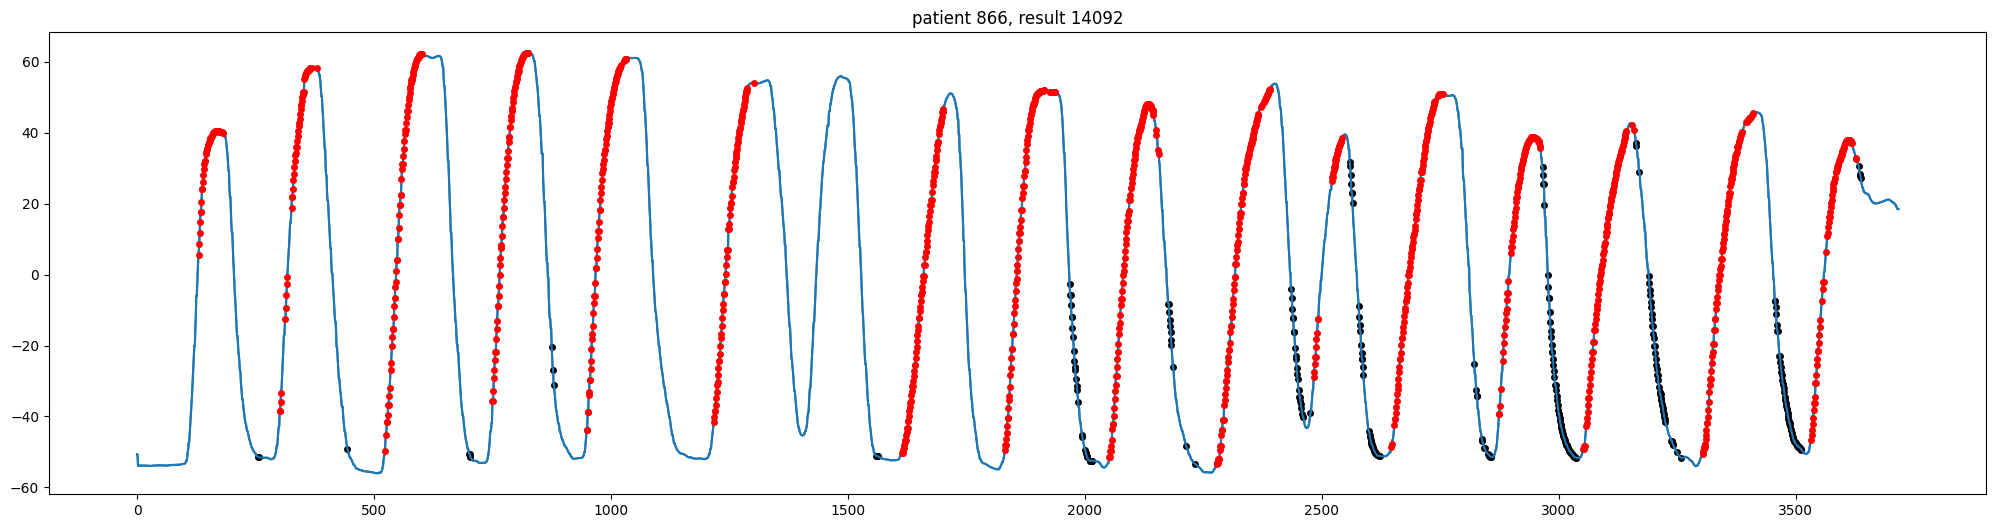

<Figure size 640x480 with 0 Axes>

In [219]:
plot_mark_ranges_preds(result_id=14092, key='position_type')


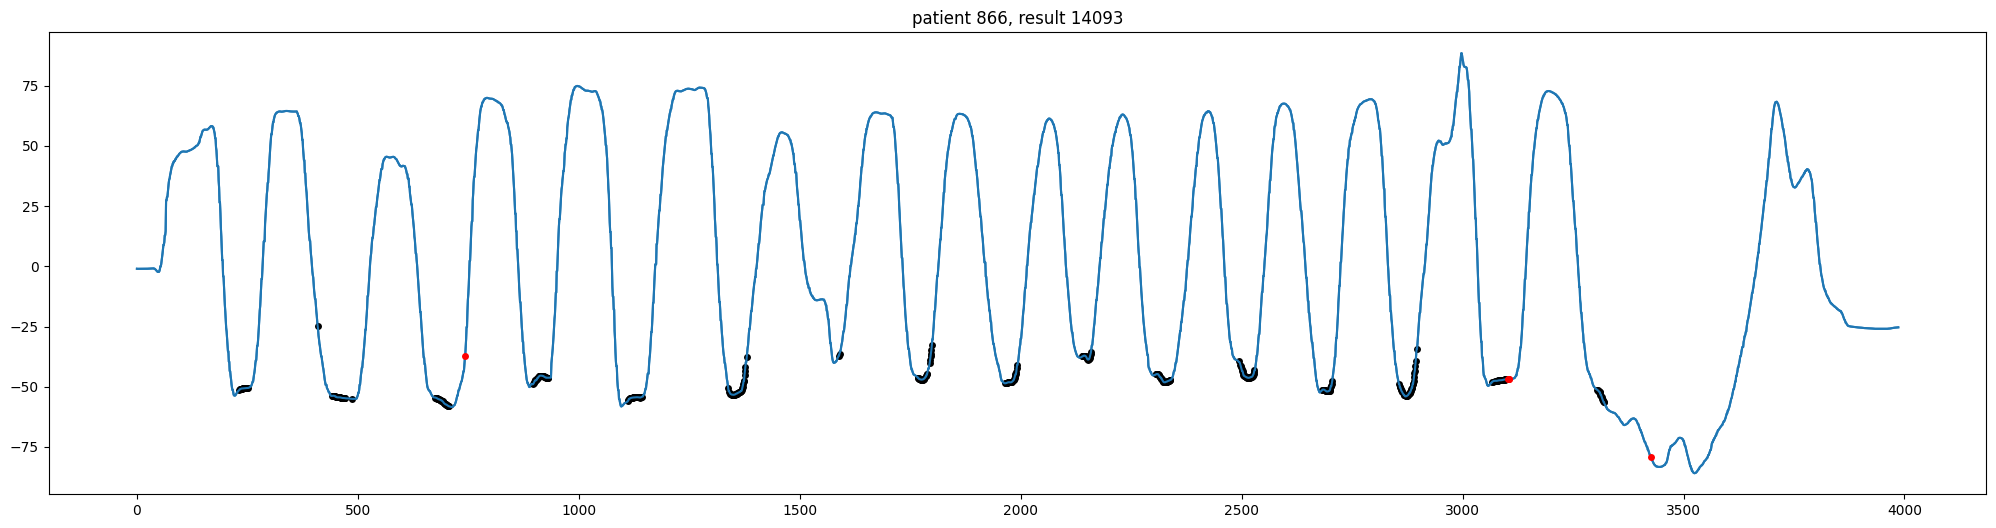

<Figure size 640x480 with 0 Axes>

In [220]:
plot_mark_ranges_preds(result_id=14093, key='position_type')


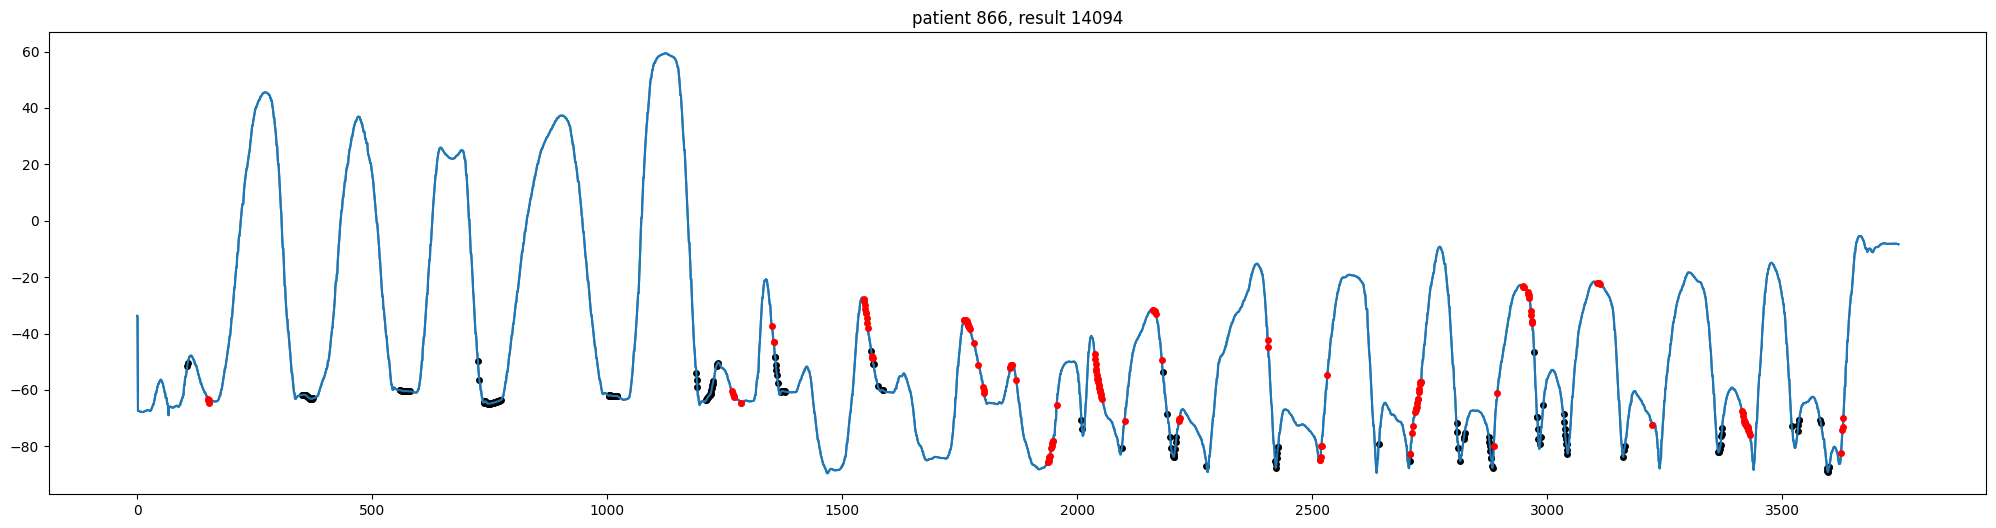

<Figure size 640x480 with 0 Axes>

In [221]:
plot_mark_ranges_preds(result_id=14094, key='position_type')


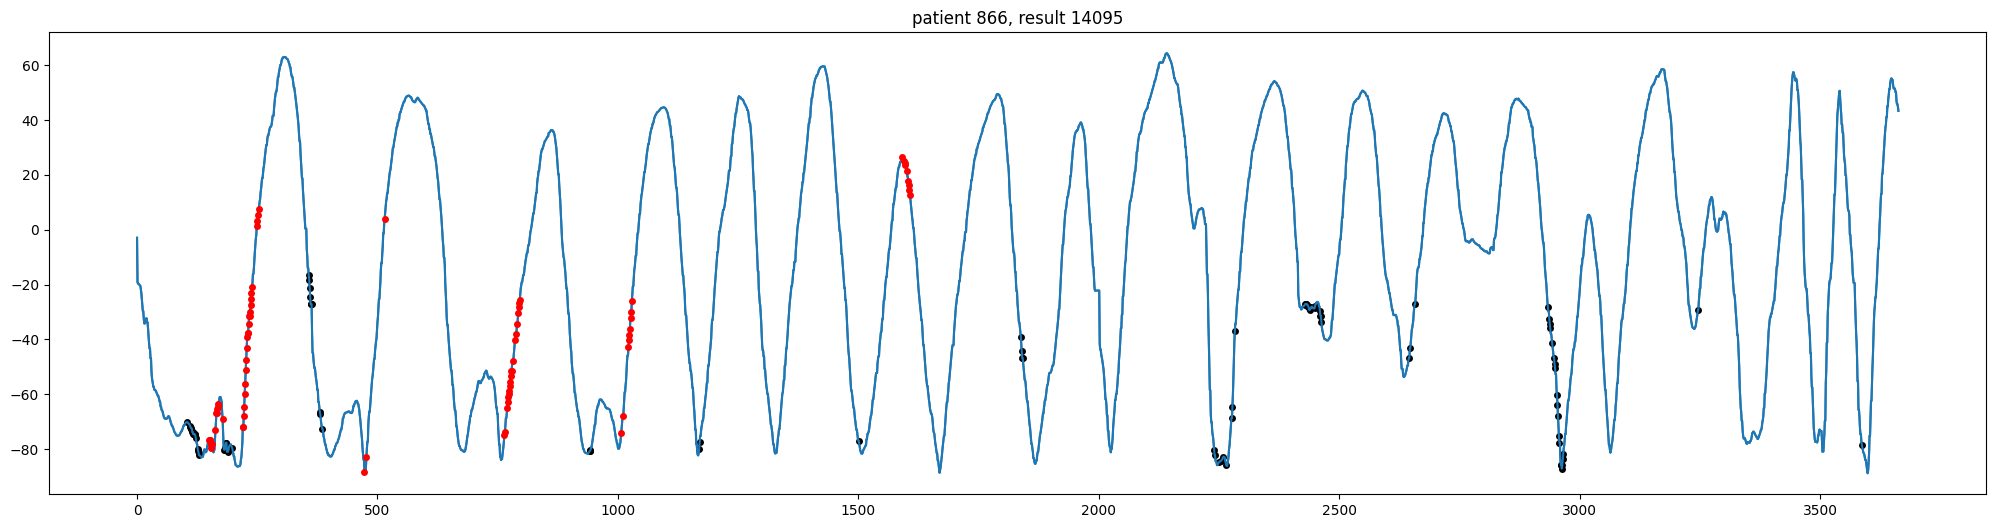

<Figure size 640x480 with 0 Axes>

In [222]:
plot_mark_ranges_preds(result_id=14095, key='position_type')


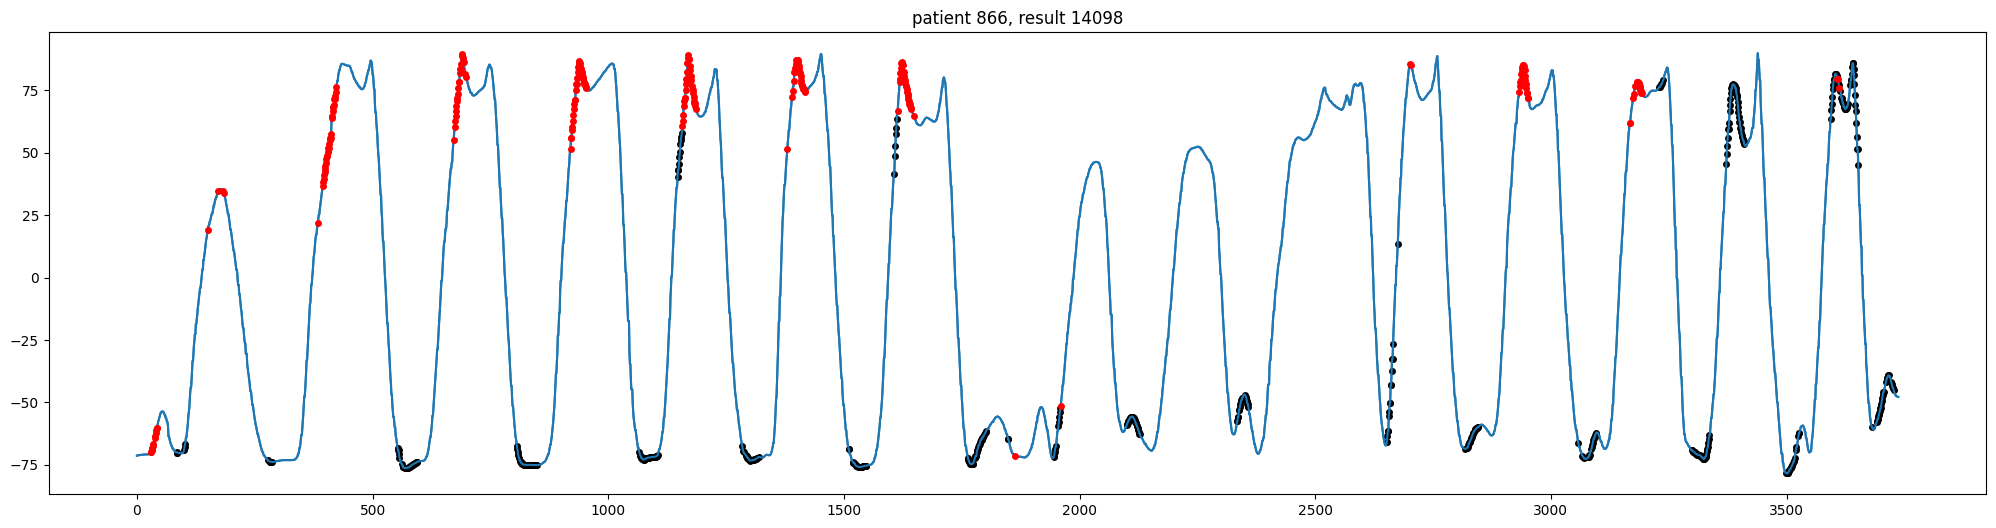

<Figure size 640x480 with 0 Axes>

In [223]:
plot_mark_ranges_preds(result_id=14098, key='position_type')


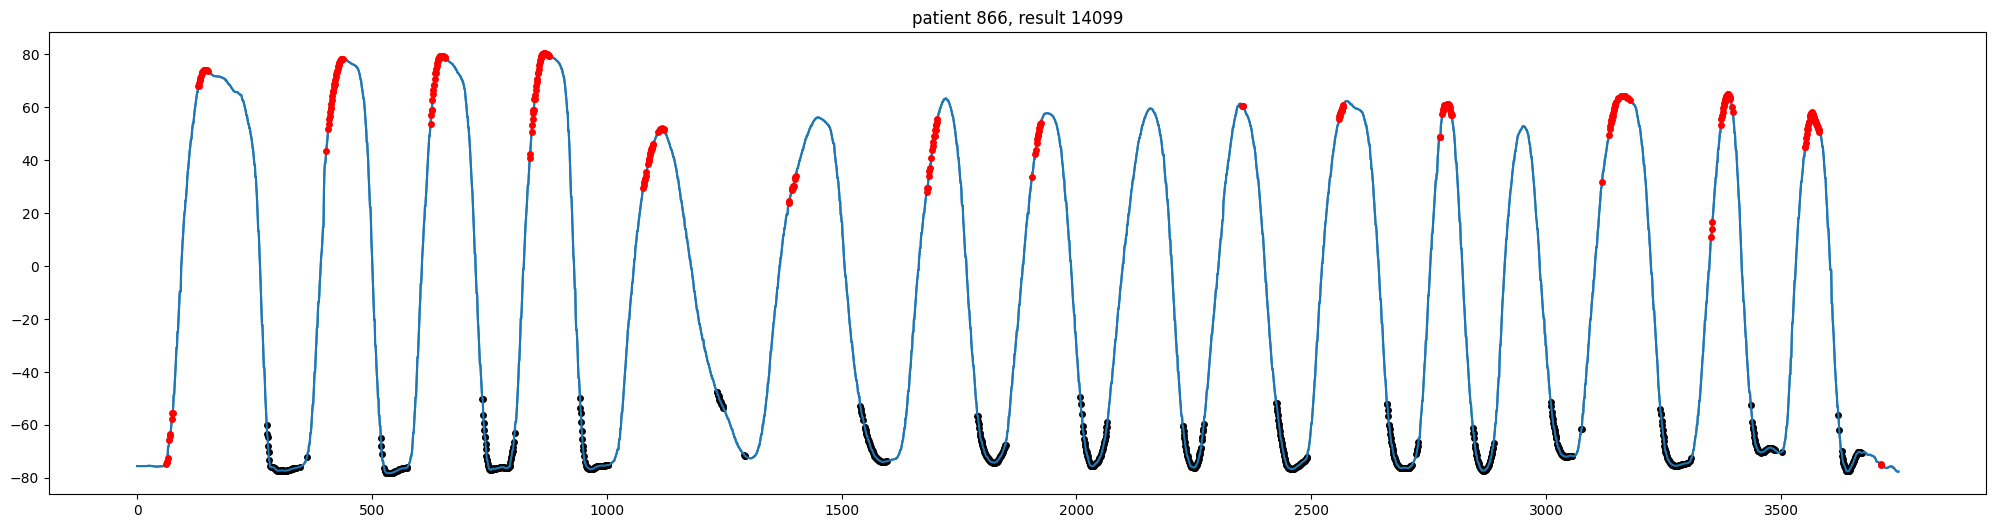

<Figure size 640x480 with 0 Axes>

In [224]:
plot_mark_ranges_preds(result_id=14099, key='position_type')


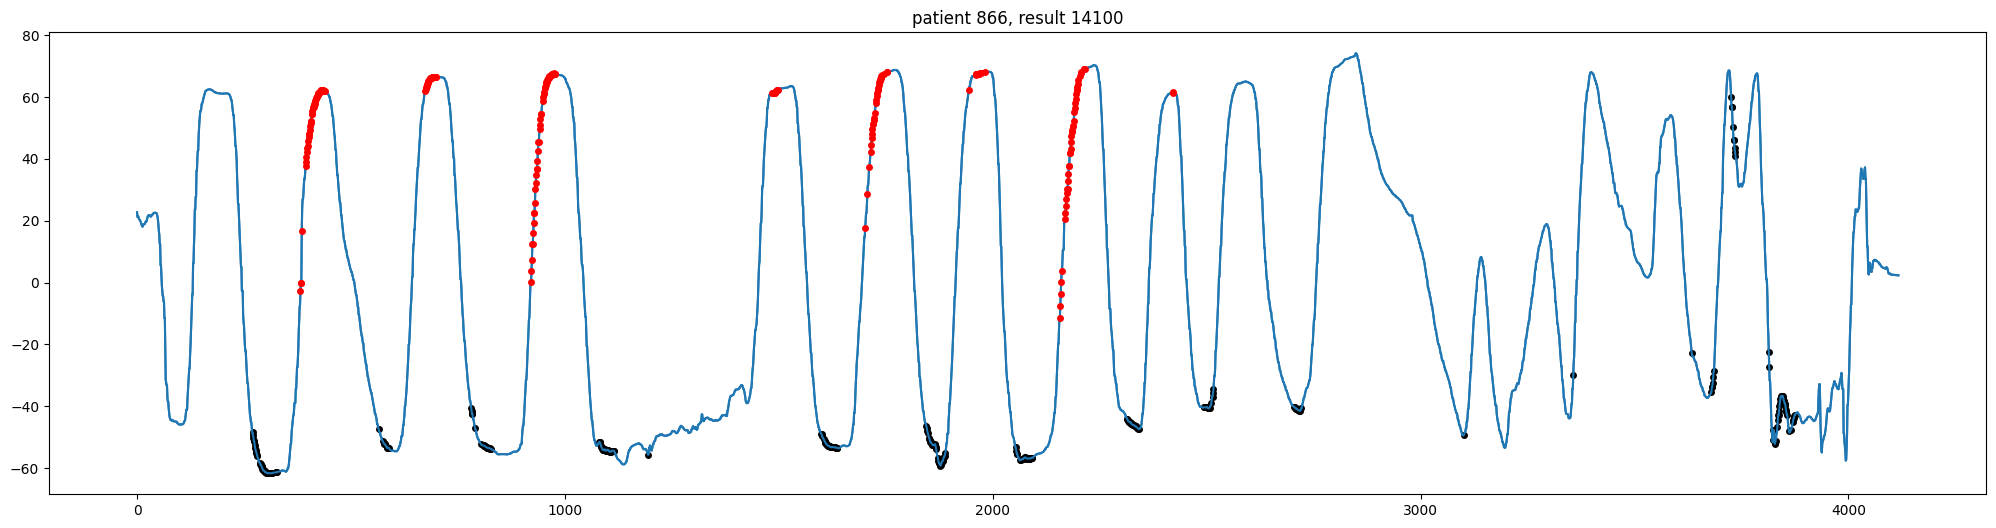

<Figure size 640x480 with 0 Axes>

In [225]:
plot_mark_ranges_preds(result_id=14100, key='position_type')


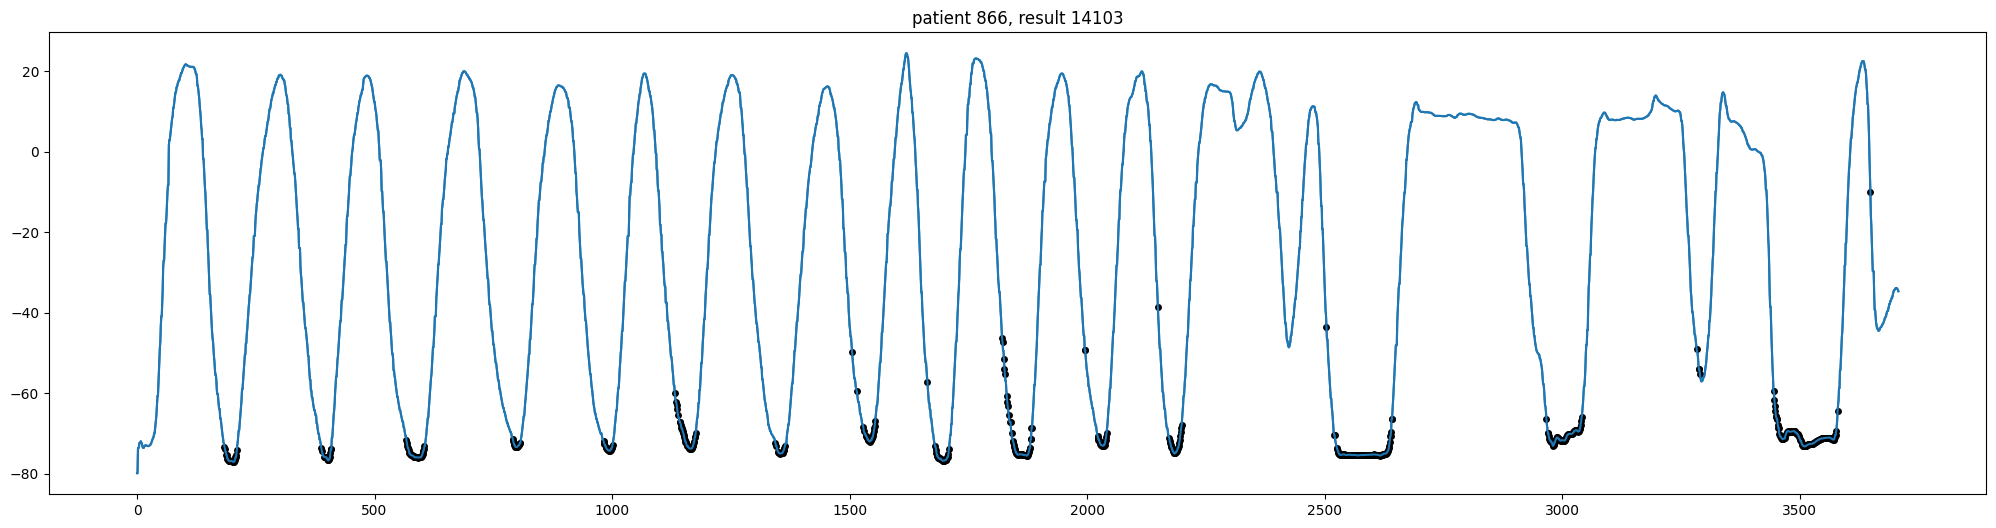

<Figure size 640x480 with 0 Axes>

In [228]:
plot_mark_ranges_preds(result_id=14103, key='position_type')
